# Radio Recievers and HI Detection

In [3]:
from matplotlib import pyplot as plt
import csv
import numpy as np
from astropy import units as u
import matplotlib
from astropy import constants as apyconst
from IPython.display import Image
matplotlib.rcParams['figure.figsize'] = [8, 4]

# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
#jtplot.style(theme="onedork",grid=False, figsize=[10,6])
#jtplot.reset()
#matplotlib.rcParams['figure.figsize'] = [8, 4]
%matplotlib notebook

# Data Analysis

## Day1 Galactic Test Data 

<IPython.core.display.Javascript object>


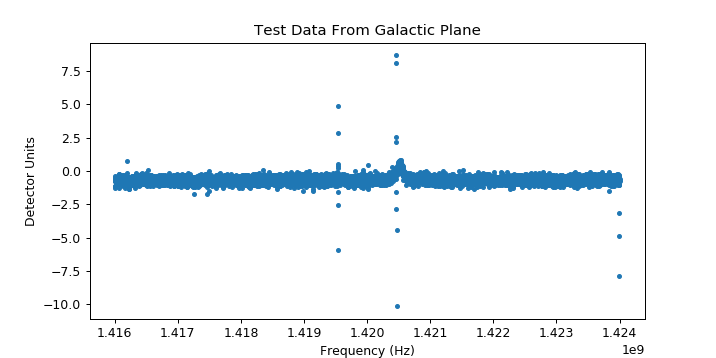

Text(0.5, 1.0, 'Test Data From Galactic Plane')

In [4]:
def get_data(path, clean = True):
    alt = np.loadtxt(path,delimiter=',')
    if clean:
        alt_off = np.loadtxt('day_1/5min_off_altair.csv', delimiter=',')
        alt[::,1] = alt[::,1] - alt_off[::,1]
    return alt

data = get_data('day_1/5min_altair.csv')

plt.figure("data_test")
plt.plot(data[::,0],data[::,1],'.')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Detector Units")
plt.title("Test Data From Galactic Plane")

## Vector Analyzer Data

In [13]:
s = np.loadtxt('vector_analyzer/S.csv',delimiter=',', skiprows=18)
s2 = np.loadtxt('vector_analyzer/S2.csv',delimiter=',',skiprows=18)
bp = np.loadtxt('vector_analyzer/2BP.csv',delimiter=',',skiprows=18)
lbp  = np.loadtxt('vector_analyzer/LBP.csv',delimiter=',',skiprows=18)
sbp  = np.loadtxt('vector_analyzer/SBP.csv',delimiter=',',skiprows=18)

<IPython.core.display.Javascript object>


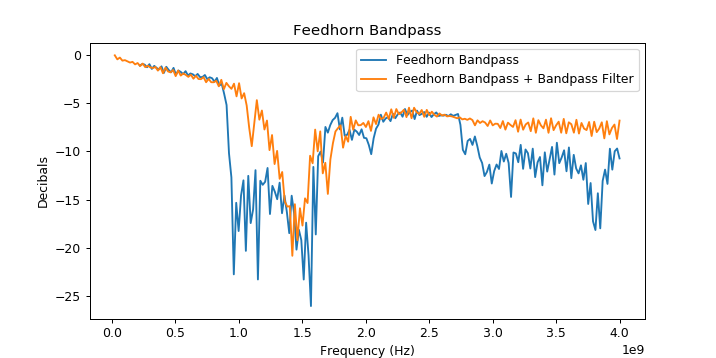

In [14]:
plt.figure("Vector")
plt.plot(s[::,0],s[::,1], label = "Feedhorn Bandpass")
plt.plot(bp[::,0],bp[::,1], label = "Feedhorn Bandpass + Bandpass Filter")
plt.title('Feedhorn Bandpass')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Decibals")
plt.legend()

## Peak Detection Algorithm 

In [6]:
def get_signal(data, filter = False, sigma = 50):
    """This function finds the location of the most prominent peak in a signal
    and performs gaussian filtering of the signal"""
    #Import nvecessary libraries
    from scipy.ndimage import gaussian_filter
    from scipy.signal import find_peaks, peak_prominences
    
    #Check if filtering required
    y = data
    if filter:
        y = gaussian_filter(y,sigma)

    #Get all signal peaks
    peaks, _ = find_peaks(y)

    #Get peak prominances
    proms = peak_prominences(y,peaks)

    #Get the most prominant peak
    peak, _ = find_peaks(y,prominence=np.max(proms[0]))
    
    return y, peak[0]

## Data Import & Visualization Tools

In [7]:
# returns x = frequencies y= signal
def import_data(path,path_baseline = None,remove_base = True):
    """This function imports data from a given path"""
    data = np.loadtxt(path, delimiter=",")
    if remove_base:
        off = np.loadtxt(path_baseline, delimiter=",")
        return data[::,0],data[::,1] - off[::,1]
    return data[::,0], data[::,1]

In [8]:
# Generates a plot of filtered signal
def plot_peak(x,y, sigma = 50, fig_name = ""):
    """Clean plot of imported data for visualization"""
    signal,peak = get_signal(y, filter = True, sigma = sigma)
    plt.figure(fig_name)
    plt.plot(x,signal)
    plt.plot(x[peak],signal[peak],'.')
    print("Peak Frequency is",x[peak],"Hz") 

### Testing 3-4 

<IPython.core.display.Javascript object>


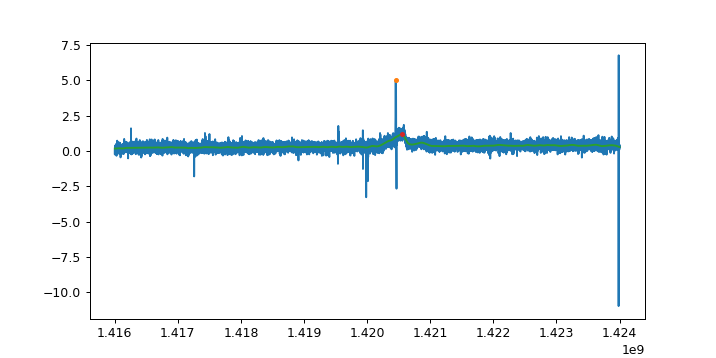

Peak Frequency is 1420451972.22841 Hz
Peak Frequency is 1420544136.72067 Hz


In [9]:
x,y = import_data("day_2/altair.csv","day_2/off.csv",remove_base=True)
plot_peak(x,y, fig_name="t", sigma=0)
plot_peak(x,y, fig_name="t", sigma=50)

## Data Analysis 

### Importing Data 

In [15]:
%%bash
# Create files with file names
ls day_1 > ls_d1.txt
ls day_2 > ls_d2.txt
ls sun_1 > ls_s1.txt

In [21]:
# Load files containing file names
day_1_files = np.loadtxt("ls_d1.txt",dtype = str)
day_2_files = np.loadtxt("ls_d2.txt",dtype = str)
sun_files = np.loadtxt("ls_s1.txt",dtype = str)

# Set up dictionaries for data importation
data_1 = {}
data_2 = {}
data_sun = {}

for i in range(len(day_2_files)):
    data_2[day_2_files[i][0:-4].lower()] = np.loadtxt("day_2/"+day_2_files[i], dtype=str, delimiter=',')
    
for i in range(len(day_1_files)):
    data_1[day_1_files[i][0:-4]] = np.loadtxt("day_1/"+day_1_files[i], dtype=str, delimiter=',')
    
for i in range(len(sun_files)):
    data_sun[sun_files[i][0:-4]] = np.loadtxt("sun_1/"+sun_files[i], dtype=str, delimiter=',')

### Location Analysis 

In [22]:
def get_coord(arr):
    from astropy.coordinates import SkyCoord
    
    ra = arr[1] +'h' + arr[2] + 'm' + arr[3] + 's'
    dec = arr[4] +'d' + arr[5] + 'm' + arr[6] + 's'
    coord = SkyCoord(ra,dec)
    
    return coord

In [27]:
locations = {} #astropy coord locations in ra and dec
locg = {} #astropy galactic coords for measurments
for i in range(len(data_2['locations']) -3):
    locations[data_2['locations'][i+1][0].lower()] = get_coord(data_2['locations'][i+1])
    locg[data_2['locations'][i+1][0].lower()] = get_coord(data_2['locations'][i+1]).galactic

### Galactic Plane Data Analysis 

#### Peak Location Vs Galactic Coords

In [53]:
keys = list(locg.keys())
longs = []
peaks = []

for i in range(len(keys)):
    x = data_2[keys[i]].astype(float)[::,0]
    y = data_2[keys[i]].astype(float)[::,1]
    
    signal, peak = get_signal(y, filter=True)
    long = locg[keys[i]].l.deg
    
    peaks.insert(i, x[peak])
    longs.insert(i,long)
    
    print(x[peak],long)

1420531929.50315 47.89122852255971
1420494087.12885 84.39978881866963
1420516670.48125 65.83407797022322
1420555123.21643 42.29422612003715
1420472114.13732 99.43009235564668
1420452582.58929 112.88014752648304
1420503852.90286 58.93488377001872
1420466620.88943 99.12262558872311


<IPython.core.display.Javascript object>


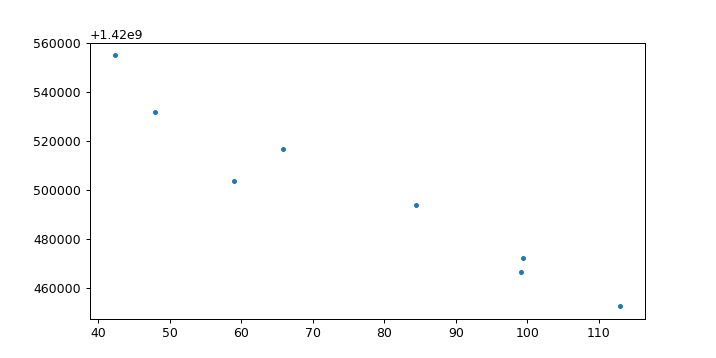

In [54]:
plt.figure()
plt.plot(longs,peaks,'.')

In [32]:
for i in range(len(keys)):
    print(data_2[keys[i]].astype(float))

[[ 1.41600000e+09 -6.41844900e+01]
 [ 1.41600061e+09 -6.42474700e+01]
 [ 1.41600122e+09 -6.43768400e+01]
 ...
 [ 1.42399817e+09 -6.31157400e+01]
 [ 1.42399878e+09 -6.32897900e+01]
 [ 1.42399939e+09 -6.32585200e+01]]
[[ 1.41600000e+09 -6.45955100e+01]
 [ 1.41600061e+09 -6.46565800e+01]
 [ 1.41600122e+09 -6.51131100e+01]
 ...
 [ 1.42399817e+09 -6.37200100e+01]
 [ 1.42399878e+09 -6.36335100e+01]
 [ 1.42399939e+09 -6.34908000e+01]]
[[ 1.41600000e+09 -6.42365400e+01]
 [ 1.41600061e+09 -6.43054900e+01]
 [ 1.41600122e+09 -6.44882300e+01]
 ...
 [ 1.42399817e+09 -6.36279600e+01]
 [ 1.42399878e+09 -6.36072700e+01]
 [ 1.42399939e+09 -6.35268500e+01]]
[[ 1.41600000e+09 -6.16225400e+01]
 [ 1.41600061e+09 -6.16167000e+01]
 [ 1.41600122e+09 -6.22860700e+01]
 ...
 [ 1.42399817e+09 -6.12252600e+01]
 [ 1.42399878e+09 -6.12600100e+01]
 [ 1.42399939e+09 -6.13324100e+01]]
[[ 1.41600000e+09 -6.43525900e+01]
 [ 1.41600061e+09 -6.40374000e+01]
 [ 1.41600122e+09 -6.43395800e+01]
 ...
 [ 1.42399817e+09 -6.36610

In [198]:
keys[1].lower()

'deneb'

In [180]:
list(locg.values())[1].l

<Longitude 84.39978882 deg>

<IPython.core.display.Javascript object>


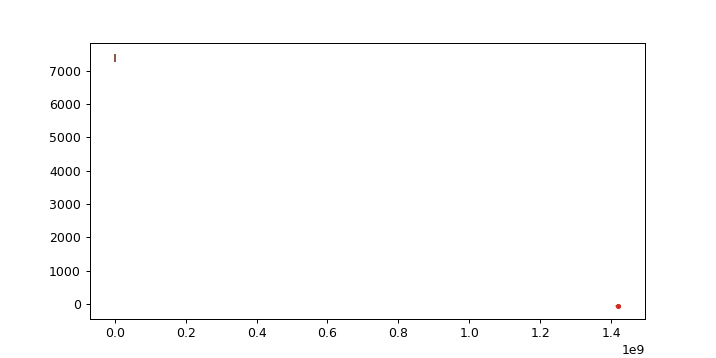

Peak Frequency is 1420455634.39367 Hz
Peak Frequency is 1420531929.50315 Hz


In [42]:
x = data_2['altair'].astype(float)[::,0]
y = data_2['altair'].astype(float)[::,1]

plot_peak(x,y,sigma=10)
plot_peak(x,y)

## Playground 

<IPython.core.display.Javascript object>


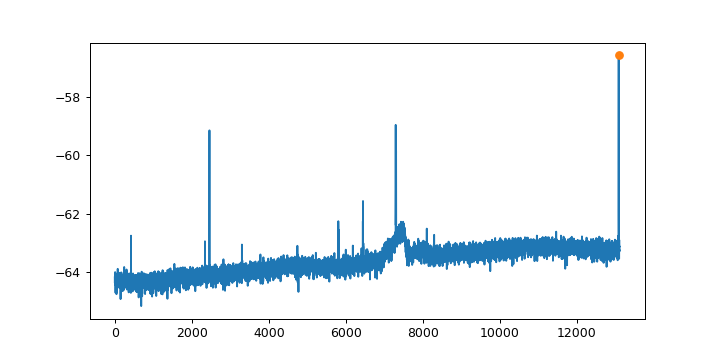

In [10]:
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks, peak_prominences
sun_0 = np.loadtxt("day_2/altair.csv", delimiter=",")
plt.figure("lay")
y = gaussian_filter(sun_0[::,1],0)
#plt.plot(sun_0[::,0],gaussian_filter(sun_0[::,1],1))
peaks, _ = find_peaks(y)
proms = peak_prominences(y,peaks)
peaks, _ = find_peaks(y, prominence= np.max(proms[0]))
plt.plot(y)
plt.plot(peaks,y[peaks], "o")

<IPython.core.display.Javascript object>


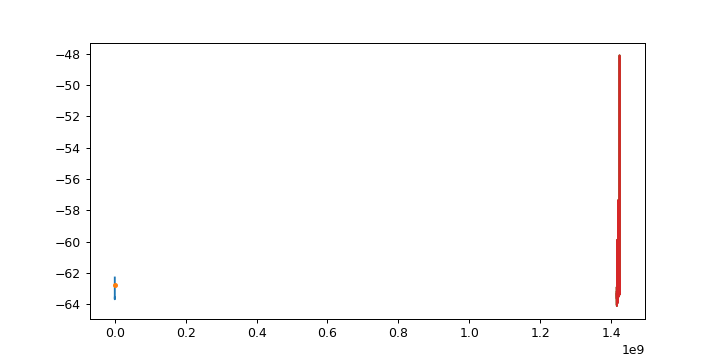

In [33]:
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks, peak_prominences
sun_0 = np.loadtxt("day_2/sun_on.csv", delimiter=",")
off = np.loadtxt("day_2/off.csv", delimiter=",")
plt.figure("mu")
y = gaussian_filter(sun_0[::,1] ,50)
#plt.plot(sun_0[::,0],gaussian_filter(sun_0[::,1],1))
peaks, _ = find_peaks(y)
proms = peak_prominences(y,peaks)
peaks, _ = find_peaks(y, prominence= np.max(proms[0]))
plt.plot(y)
plt.plot(peaks,y[peaks], ".")

In [34]:
peaks

array([7303])

# mean

In [8]:
sun_0 = np.loadtxt("sun_0.csv", delimiter=",")
sun_1 = np.loadtxt("sun_1.csv", delimiter=",")
sun_2 = np.loadtxt("sun_2.csv", delimiter=",")
sun_3 = np.loadtxt("sun_3.csv", delimiter=",")

In [2]:
ls

5min_altair.csv      gal1_zoom.png                 sun_0.csv  sun_4.csv
5min_off_altair.csv  horn.png                      sun_1.csv  vector_analyzer/
Analysis.ipynb       Lab3_AST2050_2019_Winter.pdf  sun_2.csv  vector.png
gal1_onoff.png       locations.xlsx                sun_3.csv


<IPython.core.display.Javascript object>


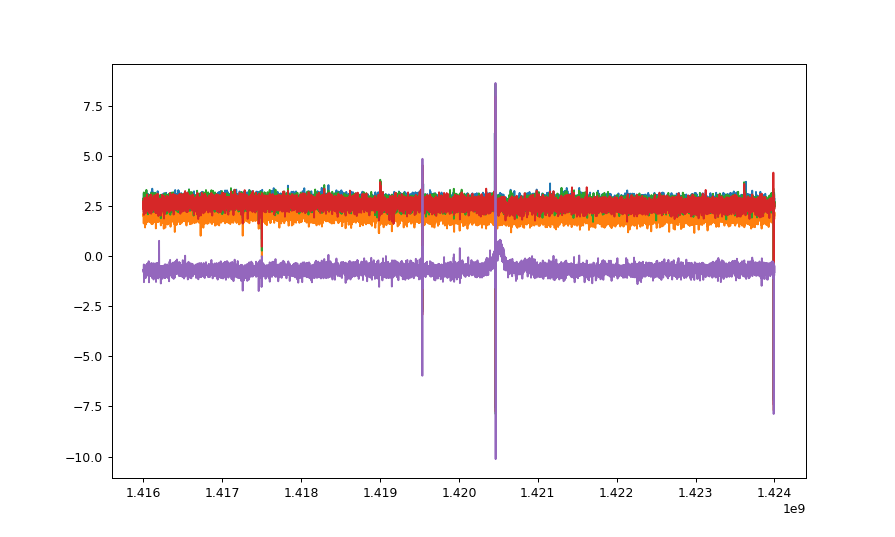

In [22]:
plt.figure("sun")
plt.plot(sun_0[::,0],sun_0[::,1] -alt_off[::,1])
plt.plot(sun_1[::,0],sun_1[::,1]  -alt_off[::,1])
plt.plot(sun_2[::,0],sun_2[::,1] -alt_off[::,1])
plt.plot(sun_3[::,0],sun_3[::,1] -alt_off[::,1])
plt.plot(data[::,0],data[::,1])

In [15]:
alt_off = np.loadtxt('5min_off_altair.csv', delimiter=',')

<IPython.core.display.Javascript object>


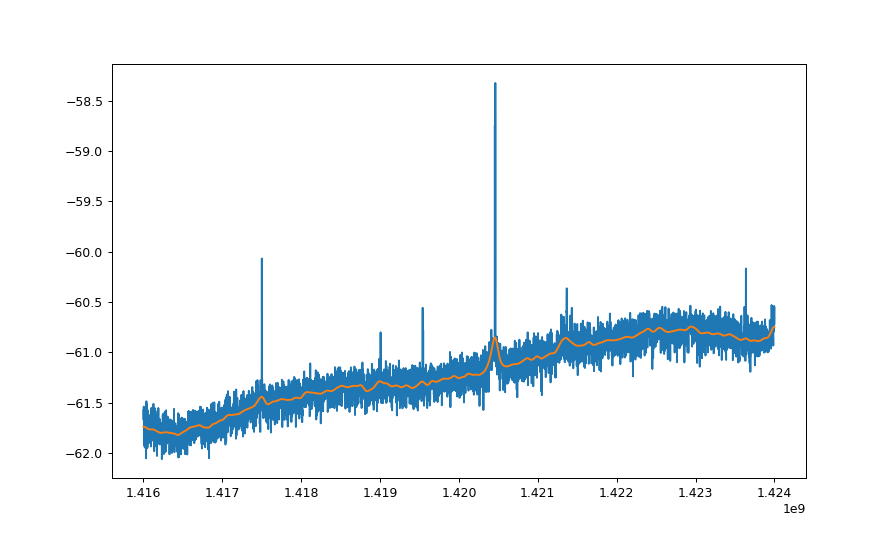

In [42]:
from scipy.ndimage import gaussian_filter
plt.figure()
plt.plot(sun_0[::,0],gaussian_filter(sun_0[::,1],1))
plt.plot(sun_0[::,0],gaussian_filter(sun_0[::,1],50))